# 批量归一化

### 出现的原因
- 损失出现在最后，后面的层训练较快
- 数据在最底部
  - 底部的层训练较慢（上面梯度大，训练快）
  - 底部层一变化，所有都得跟着变（上面训练差不多的权重都白学）
  - 最后的那些层需要学习多次
  - 导致收敛变慢
- 怎么可以在学习底部层的时候避免变化顶部层

### 反复出现的主题
- 优化中的**各种噪声**通常会导致更快的训练和较少的过拟合——这种变化似乎是正则化的一种形式

### 批量归一化层
- *训练模式*：通过**小批量**统计数据规范化。在训练中无法得知并使用整个数据集来估计平均和方差
- *预测模式*：通过**数据集**统计规范化。在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和方差

### 核心想法
- 固定小批量里面的均值和方差（$\epsilon$确保永远不会尝试除以0）
$$
\mu_B = \frac{1}{|B|} \sum_{i \in B} x_i \quad \text{and} \quad \sigma_B^2 = \frac{1}{|B|} \sum_{i \in B} (x_i - \mu_B)^2 + \epsilon
$$
然后再做额外的调整（可学习的参数）
$$
x_{i+1} = \gamma \frac{x_i - \mu_B}{\sigma_B} + \beta
$$
其中$\gamma$是方差，$\beta$是均值，都是可学习的参数
- 在模型训练过程中，批量规范化利用小批量的均值和标准差，不断调整神经网络的*中间输出*，使整个神经网络各层的中间输出值更加稳定

### 批量归一化层
- 可学习的参数为$\gamma$和$\beta$
- 作用在
  - 全连接层和卷积层输出上，激活函数前
  - 全连接层和卷积层输入上
- 对**全连接层**，作用在**特征维**
- 对**卷积层**，作用在**通道维**
  - 每个通道都有自己的scale和shift，两个参数都是标量
  - 假设小批量包含$m$个样本，且对每个通道，卷积的输出具有高度$p$和宽度$q$，则在每个输出通道的$m \times p \times q$个元素上同时执行每个批量规范化
  - 对于$1\times1$卷积层，等价与一个全连接层，是将每个像素都看成一个样本，一共（`batch_size * height * width`）个样本，可认为n个通道就是像素的特征——这样拉成一个二维矩阵后做一个全连接
  - 作用在通道维的原理，类似于这里说的$1\times1$卷积层

### 批量归一化在做什么
- 最初论文是想用它来减少内部协变量转移
- 后面发现*可能*就是通过**在每个小批量里加入噪音**来控制模型复杂度
$$
_{i+1} = \gamma \frac{x_i - \hat{\mu}_B}{\hat{\sigma}_B} + \beta
$$
其中$\hat{\mu}_B$和$\hat{\sigma}_B$是**随机偏移**和**随机缩放**  
$\gamma$和$\beta$学习得到，使变化不那么剧烈且有随机性
- 因此没必要跟丢弃法混合使用

### 总结
- 批量归一化固定销批量中的均值和方差，然后学校出适合的偏移和缩放
- 可以加速收敛速度（可以使用**较大的学习率**），但一般不改变模型精度


### 注意
- 在**较深**的神经网络中作用会更大些，MLP上作用不大

## 代码

In [ ]:
!pip install d2l

In [ ]:
import torch

from torch import nn
from d2l import torch as d2l

#### **从0开始实现**

- `torch.is_grad_enabled()`：检查当前是否其用量**自动求导**功能，返回`True`或`False`
  - `True`：意味着上下文中pytorch会跟踪张量的操作，以便在需要时计算梯度
  - `False`：在推理（inference）或测试模式下非常有用，可以节省内存和加快计算速度

- `torch.no_grad()`——**禁用**梯度，`torch.is_grad_enabled()`返回`False`  
- `torch.enable_grad()`——**启用**梯度，`torch.is_grad_enabled()`返回`True`
- `.data`用于获取张量的原始数据

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  if not torch.is_grad_enabled():
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2, 4)
    if len(X.shape) == 2:
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      # 需要保持X的形状以便后面做广播运算
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
    X_hat = (X - mean) / torch.sqrt(var + eps)
    moving_mean = momentum * moving_mean + (1. - momentum) * mean
    moving_var = momentum * moving_var + (1. - momentum) * var
  Y = gamma * X_hat + beta
  return Y, moving_mean.data, moving_var.data

**创建正确的`BatchNorm`层**
- 保持适当的参数：`gamma`和`beta`，这两个参数将在训练过程中更新
- 层将保存均值和方差的移动平均值，以便模型在预测期间使用
- **模型的变量——需要`nn.Parameter()`**

In [ ]:
class BatchNorm(nn.Module):
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    # 参与求梯度和迭代的拉伸和偏移参数，分别初始化为1和0
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    # 非模型的变量
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self, X):
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    Y, self.moving_mean, self.moving_var =  batch_norm(
        X, self.gamma, self.beta, self.moving_mean, self.moving_var,
        eps=1e-5, momentum=0.9
    )
    return Y

#### **y应用`BatchNorm`到`LeNet`模型**


In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.261, train acc 0.903, test acc 0.847
12682.5 examples/sec on cuda:0


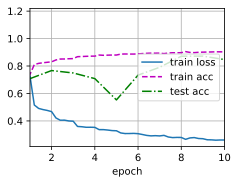

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

查看第一个批量规范化层中学到的**拉伸参数`gamma`和偏移参数`beta`**

In [ ]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1., 1., 1., 1., 1., 1.], grad_fn=<ViewBackward0>),
 tensor([0., 0., 0., 0., 0., 0.], grad_fn=<ViewBackward0>))

#### 简明实现
- `BatchNorm`
  - `BatchNorm1d`期望输入为四维张量`(batch_size, channels, height, width)`
  - `BatchNorm2d`期望输入为二维张量`(batch_size, num_features)`

loss 0.255, train acc 0.905, test acc 0.862
20861.2 examples/sec on cuda:0


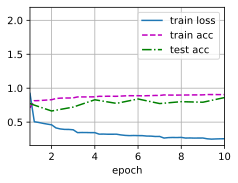

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

lr = 2.
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习
1. 在使用批量规范化之前，我们是否可以从全连接层或卷积层中删除偏置参数？为什么？
- 答
  - 在使用批量规范化时，**删除卷积层或全连接层的偏置项**是一个常见且合理的做法，因为批量规范化已经提供了相应的偏移机制
2. 比较LeNet在使用和不使用批量规范化情况下的学习率。
    - 绘制训练和测试准确度的提高。
    - 学习率有多高？

loss 0.514, train acc 0.799, test acc 0.783
26974.1 examples/sec on cuda:0


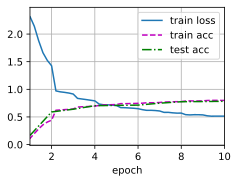

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

batch_size = 256
lr, num_epochs = 0.9, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.265, train acc 0.901, test acc 0.869
11781.9 examples/sec on cuda:0


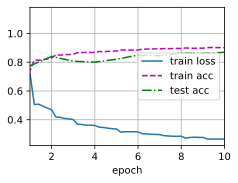

In [ ]:
bn_net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

d2l.train_ch6(bn_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

3. 是否需要再每个层中进行批量规范化？
- 答
  - 并不是所有层都需要使用`BatchNorm`，有时过度使用反而会降低模型性能

loss 0.324, train acc 0.879, test acc 0.857
14996.9 examples/sec on cuda:0


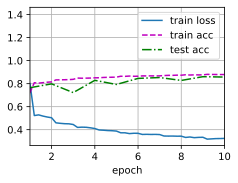

In [ ]:
all_bn_net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
    nn.Sigmoid(), nn.BatchNorm2d(6),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.BatchNorm2d(6),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
    nn.Sigmoid(), nn.BatchNorm2d(16),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.BatchNorm2d(16),
    nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120),
    nn.Sigmoid(), nn.BatchNorm1d(120),
    nn.Linear(120, 84), nn.BatchNorm1d(84),
    nn.Sigmoid(), nn.BatchNorm1d(84),
    nn.Linear(84, 10)
)


d2l.train_ch6(all_bn_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

4. 可以通过批量归一化来替换暂退法吗？
- 答
  - 可以，但是一般都是直接进行替换，不会同时用，因为两者都是起到**正则项**的作用
5. 确定参数`beta`和`gamma`，并观察和分析结果

loss 0.254, train acc 0.907, test acc 0.854
24463.2 examples/sec on cuda:0


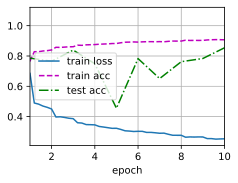

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  if not torch.is_grad_enabled():
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2, 4)
    if len(X.shape) == 2:
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
    X_hat = (X - mean) / torch.sqrt(var + eps)
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
  Y = gamma * X_hat + beta  # 缩放和移位
  return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
        shape = (1, num_features)
    else:
        shape = (1, num_features, 1, 1)
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))

    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self, X):
    if self.moving_mean.device != X.device:
        self.moving_mean = self.moving_mean.to(X.device)
        self.moving_var = self.moving_var.to(X.device)

    Y, self.moving_mean, self.moving_var = batch_norm(
        X, self.gamma, self.beta, self.moving_mean,
        self.moving_var, eps=1e-5, momentum=0.9
    )
    return Y

BN_net = nn.Sequential(
      nn.Conv2d(1, 6, kernel_size=5, padding=2),
      BatchNorm(6, num_dims=4), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Conv2d(6, 16, kernel_size=5),
      nn.BatchNorm2d(16), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(16 * 5 * 5, 120), nn.BatchNorm1d(120),
      nn.Sigmoid(),
      nn.Linear(120, 84), nn.BatchNorm1d(84),
      nn.Sigmoid(),
      nn.Linear(84, 10)
    )

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.5, 10
d2l.train_ch6(BN_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

6. 研究思路：可以应用的其他“规范化”转换？可以应用概率积分变换吗？全秩协方差估计可以么？
- 答
  - “规范化”转换：
    - 层归一化Layer Normaliztion，在每个样本的特征维上进行归一化，而不是跨批次
    - 实例归一化Instance Normalization，主要用于风格迁移，将每个样本每个通道单独归一化，通常用于图像生成任务
    - 组归一化Group Normalization，将通道分成多个组，在每组内进行归一化，适合小批量情况
  - Probability Integral Transform，用于将任意分布的随机变量转换为均匀分布的技术，这种方法适用于需要将数据转化为某种标准分布的场景，可能会增强模型的鲁棒性
  - 全秩协方差估计，可以用于特征规范化，尤其在高维数据分析中
- 总结
  - 不同的规范化技术适用于不同的任务和数据特征，选择合适的方法可以提高模型的性能和收敛速度
  - 概率积分变换和全秩协方差估计虽然不直接属于传统的规范化方法，但在特征处理和理解数据结构方面可以发挥重要作用